In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

### Data Load and Visualization

This section loads the dataset and visualizes the first few rows to understand its structure. MNIST is a dataset of handwritten digits, commonly used for training various image processing systems. We are using this dataset to train a simple neural network model that recognizes handwritten digits.

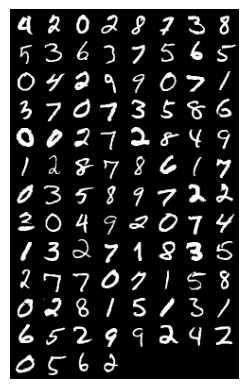

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [2]:
traindata = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(traindata, batch_size=100, shuffle=True, num_workers=1)
validationSet = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
validationloader = torch.utils.data.DataLoader(validationSet, batch_size=100, shuffle=False, num_workers=1)

dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(traindata.data.shape)
print(validationSet.data.shape)

In [3]:
print(' '.join(f'{labels[j]}' for j in range(4)))

# Iamge Shape: (1, 28, 28) = (channels, height, width)
print(f'Image size: {images[0].size()}')

4 2 0 2
Image size: torch.Size([1, 28, 28])


### Determine which device to use for training

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


### Load the Nueral Network Model

In [5]:
from model import NeuralNetwork

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### Training the Model

In [6]:
# Parameters
num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0005

# Lists to hold metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == y.long()).sum().item()
        total += y.size(0)
    
    avg_train_loss = total_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

### Plot the Loss and Accuracy over Epochs

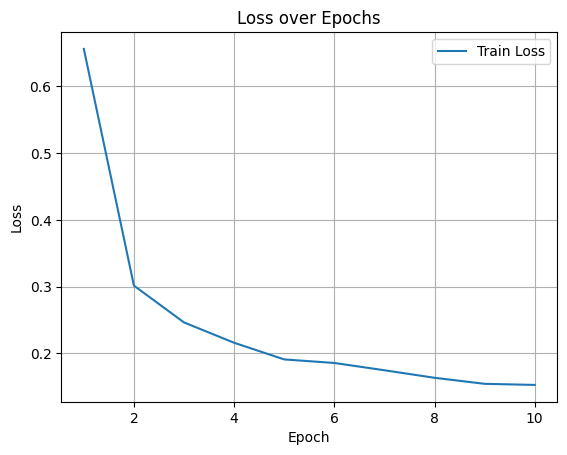

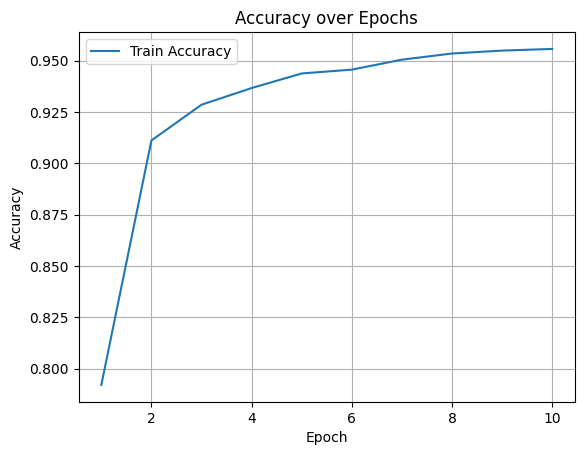

In [7]:
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
acc = Accuracy(task="multiclass", num_classes=10).to(device)
model.eval()
with torch.no_grad():
    for x, y in validationloader:
        x, y = x.to(device).float(), y.to(device).long()
        output = model(x)
        acc.update(output, y)
print(f"Validation Accuracy: {acc.compute().item() * 100:.2f}%")

Validation Accuracy: 98.65%


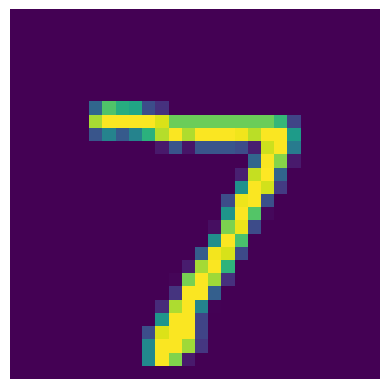

Predicted label: 7


In [9]:
example = validationSet[0][0].unsqueeze(0).to(device)
# Display the example image
imshow(example.cpu().squeeze(0))
output = model(example)
_, predicted = torch.max(output.data, 1)
print(f'Predicted label: {predicted.item()}')

### Save the Model for Future Use

In [10]:
# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')